In [1]:
# Data wrangling 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statistics import mode

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

In [2]:
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE

from sklearn.metrics import mean_squared_error, r2_score


In [3]:
data = pd.read_pickle("C:/Users/Daniella/Forage ANZ/data.pkl")
data.head()

,status,card_present_flag,account,long_lat,txn_description,merchant_id,first_name,balance,date,gender,...,extraction,amount,transaction_id,customer_id,merchant_long_lat,movement,month,dayofweek,hour,category
0,authorized,1,ACC-1598451071,153.41 -27.95,POS,81c48296-73be-44a7-befa-d053f48ce7cd,Diana,35.39,2018-08-01,F,...,01:01:15,16.25,a623070bfead4541a6b0fff8a09e706c,CUS-2487424745,153.38 -27.99,debit,8,2,1,Purchase
1,authorized,0,ACC-1598451071,153.41 -27.95,SALES-POS,830a451c-316e-4a6a-bf25-e37caedca49e,Diana,21.20,2018-08-01,F,...,01:13:45,14.19,13270a2a902145da9db4c951e04b51b9,CUS-2487424745,151.21 -33.87,debit,8,2,1,Purchase
2,authorized,1,ACC-1222300524,151.23 -33.94,POS,835c231d-8cdf-4e96-859d-e9d571760cf0,Michael,5.71,2018-08-01,M,...,01:26:15,6.42,feb79e7ecd7048a5a36ec889d1a94270,CUS-2142601169,151.21 -33.87,debit,8,2,1,Purchase
3,authorized,1,ACC-1037050564,153.10 -27.66,SALES-POS,48514682-c78a-4a88-b0da-2d6302e64673,Rhonda,2117.22,2018-08-01,F,...,01:38:45,40.90,2698170da3704fd981b15e64a006079e,CUS-1614226872,153.05 -26.68,debit,8,2,1,Purchase
4,authorized,1,ACC-1598451071,153.41 -27.95,SALES-POS,b4e02c10-0852-4273-b8fd-7b3395e32eb0,Diana,17.95,2018-08-01,F,...,01:51:15,3.25,329adf79878c4cf0aeb4188b4691c266,CUS-2487424745,153.44 -28.06,debit,8,2,1,Purchase


In [4]:
# Dataframe columns 
pd.DataFrame({"Columns": data.columns})

,Columns
0,status
1,card_present_flag
2,account
3,long_lat
4,txn_description
5,merchant_id
6,first_name
7,balance
8,date
9,gender


In [5]:
feat=data[['age','amount','balance']]
feat.head()

,age,amount,balance
0,26,16.25,35.39
1,26,14.19,21.20
2,38,6.42,5.71
3,40,40.90,2117.22
4,26,3.25,17.95


<AxesSubplot:xlabel='age', ylabel='balance'>

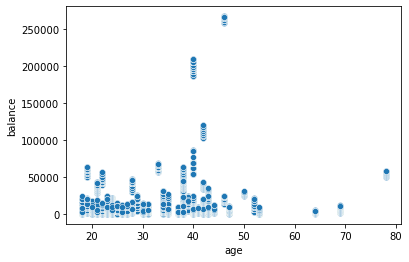

In [6]:
sns.scatterplot(x=data['age'],y=data['balance'],data=feat)

Inference - As per age we can see that 40-50 year age bracket people have maintained  a higher bank balance .  

<AxesSubplot:xlabel='age', ylabel='amount'>

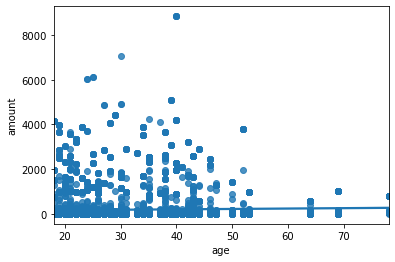

In [7]:
sns.regplot(x=data['age'],y=data['amount'],data=feat)

# 2. Feature engineering - 

In order to model annual salary, we first need to compute the annual salary for each customer as well as create features that can help us predict those salaries.

# 2.1 Target variable (customers' annual salary)
A target variable, or sometimes called a response variable, is the variable that we are trying to predict and in our case, this is the annual salary for each customer.

In [8]:
# Check the salary payment frequency of each customer
salary_df = pd.DataFrame({"customer_id": data.customer_id.unique()})
salary_df.head()

,customer_id
0,CUS-2487424745
1,CUS-2142601169
2,CUS-1614226872
3,CUS-2688605418
4,CUS-4123612273


In [9]:
example = data.loc[(data.customer_id == salary_df.customer_id[0]) & (data.txn_description == "PAY/SALARY"), ["date", "amount"]].groupby("date", as_index = False).sum()
example

,date,amount
0,2018-08-01,1013.67
1,2018-08-08,1013.67
2,2018-08-15,1013.67
3,2018-08-22,1013.67
4,2018-08-29,1013.67
5,2018-09-05,1013.67
6,2018-09-12,1013.67
7,2018-09-19,1013.67
8,2018-09-26,1013.67
9,2018-10-03,1013.67


In [10]:
# Loop through all salary payments for each customer
# Assume the salary level is constant for each customer over the observed period
df_freq = []
df_amount = []

for customer in range(len(salary_df)):
    salary = data.loc[(data.customer_id == salary_df.customer_id[customer]) & (data.txn_description == "PAY/SALARY"), ["date", "amount"]].groupby("date", as_index = False).sum()
    count = len(salary)
    if count == 0:
        df_amount.append(np.nan)
        df_freq.append(np.nan)
    else:
        days_between_payments = []
        for date in range(len(salary)-1):
            days_between_payments.append((salary.date[date + 1] - salary.date[date]).days)
        df_freq.append(max(days_between_payments))
        df_amount.append(mode(salary.amount))

salary_df["salary_freq"] = df_freq
salary_df["salary_amount"] = df_amount       
salary_df["annual_salary"] = salary_df["salary_amount"] / salary_df["salary_freq"] * 365.25
salary_df.head()

,customer_id,salary_freq,salary_amount,annual_salary
0,CUS-2487424745,7,1013.67,52891.852500
1,CUS-2142601169,7,1002.13,52289.711786
2,CUS-1614226872,7,892.09,46547.981786
3,CUS-2688605418,14,2320.30,60534.969643
4,CUS-4123612273,7,1068.04,55728.801429


Inference-There were multiple mode values for days_between_payments, so I decided to take the maximum.

C:\Users\Daniella\.conda\envs\py36_test\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Annual salary')

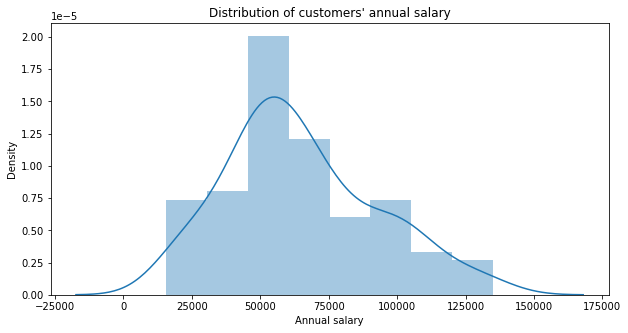

In [11]:
# Plot customer's annual salary distribution 
plt.figure(figsize = (10, 5))
sns.distplot(salary_df.annual_salary)
plt.title("Distribution of customers' annual salary")
plt.xlabel("Annual salary")

# 2.2 Predictor variables
Predictor variables or features are variables that will help us predict the salaries for each customer.

In this section, we will create the following features for each customer:

- Average number of weekly transactions
- Maximum transaction amount
- Number of large transactions (over $100)

- Number of days with transactions
- Average transaction amount
- Median balance
- State of residence
By no means this is an exhaustive list of features we can create. Feel free to come up with your own features!

Also, not to forget from our original dataframe:

Age,
Gender

In [12]:
# Unique customer id's 
unique_id = data.customer_id.unique()
len(unique_id)

100

In [13]:
unique_id[:5]

array(['CUS-2487424745', 'CUS-2142601169', 'CUS-1614226872',
       'CUS-2688605418', 'CUS-4123612273'], dtype=object)

#### 2.2.1 Average number of weekly transactions

In [14]:
avg_no_weekly_trans = []
for id_ in unique_id:
    array = data.loc[data.customer_id == id_, "date"]
    avg_no_weekly_trans.append(round(len(array)/array.nunique()*7))
avg_no_weekly_trans[:5]

[48, 29, 24, 14, 21]

#### 2.2.2 Maximum amount

In [15]:
max_amount = []
for id_ in unique_id:
    array = data.loc[data.customer_id == id_, "amount"]
    max_amount.append(max(array))
max_amount[:5]

[1452.21, 2349.55, 892.09, 2320.3, 1068.04]

#### 2.2.3 Number of large transactions

In [16]:
no_large_trans = []
for id_ in unique_id:
    count = 0
    array = data.loc[data.customer_id == id_, "amount"]
    for amount in array:
        if amount > 100:
            count += 1
    no_large_trans.append(count)
no_large_trans[:5]

[22, 23, 22, 25, 32]

#### 2.2.4 Number of days with transactions

In [17]:
no_days_with_trans = []
for id_ in unique_id:
    array = data.loc[data.customer_id == id_, "date"]
    no_days_with_trans.append(array.nunique())
no_days_with_trans[:5]

[85, 74, 76, 63, 44]

#### 2.2.5 Average transaction amount

In [18]:
avg_trans_amount = []
for id_ in unique_id:
    array = data.loc[data.customer_id == id_, "amount"]
    avg_trans_amount.append(array.mean())
avg_trans_amount[:5]

[45.34877162629756,
 78.20610561056101,
 74.46501930501928,
 159.3041860465116,
 166.50835820895517]

#### 2.2.6 Median balance

In [19]:
median_balance = []
for id_ in unique_id:
    array = data.loc[data.customer_id == id_, "balance"]
    median_balance.append(array.median())
median_balance[:5]    

[1580.4, 1132.66, 3618.5, 5616.63, 6162.45]

####  2.2.7 State of residence

In [20]:
# Assume customers live in the state where most of their transactions occured
state = []
for id_ in unique_id:
    array = data.loc[data.customer_id == id_, "merchant_state"]
    state.append(mode(array))
state[:5]

['QLD', 'NSW', 'QLD', 'NSW', 'VIC']

#### 2.2.8 Include age and gender from original dataframe

In [21]:
age = []
for id_ in unique_id:
    array = data.loc[data.customer_id == id_, "age"]
    age.append(mode(array))
age[:5]

[26, 38, 40, 20, 43]

In [22]:
gender = []
for id_ in unique_id:
    array = data.loc[data.customer_id == id_, "gender"]
    gender.append(mode(array))
gender[:5]

['F', 'M', 'F', 'M', 'F']

#### 2.2.9 Putting everything together

Here, we will put together all the features that we have created into a dataframe called features_df and subsequently concatenate the annual salary for each customer to form a final dataframe called df.

In [23]:
# Predictor variables 
features_df = pd.DataFrame({"customer_id": unique_id, 
                            "avg_no_weekly_trans": avg_no_weekly_trans, 
                            "max_amount": max_amount, 
                            "no_large_trans": no_large_trans,
                            "avg_trans_amount": avg_trans_amount,
                            "median_balance": median_balance, 
                            "state": state,
                            "age": age,
                            "gender": gender})
features_df.head()

,customer_id,avg_no_weekly_trans,max_amount,no_large_trans,avg_trans_amount,median_balance,state,age,gender
0,CUS-2487424745,48,1452.21,22,45.348772,1580.40,QLD,26,F
1,CUS-2142601169,29,2349.55,23,78.206106,1132.66,NSW,38,M
2,CUS-1614226872,24,892.09,22,74.465019,3618.50,QLD,40,F
3,CUS-2688605418,14,2320.30,25,159.304186,5616.63,NSW,20,M
4,CUS-4123612273,21,1068.04,32,166.508358,6162.45,VIC,43,F


In [24]:
# Target variable 
salary_df.head()

,customer_id,salary_freq,salary_amount,annual_salary
0,CUS-2487424745,7,1013.67,52891.852500
1,CUS-2142601169,7,1002.13,52289.711786
2,CUS-1614226872,7,892.09,46547.981786
3,CUS-2688605418,14,2320.30,60534.969643
4,CUS-4123612273,7,1068.04,55728.801429


In [25]:
# Concat annual salary column to features dataframe  
df = pd.concat([features_df, salary_df.annual_salary], axis = 1)
df.head()

,customer_id,avg_no_weekly_trans,max_amount,no_large_trans,avg_trans_amount,median_balance,state,age,gender,annual_salary
0,CUS-2487424745,48,1452.21,22,45.348772,1580.40,QLD,26,F,52891.852500
1,CUS-2142601169,29,2349.55,23,78.206106,1132.66,NSW,38,M,52289.711786
2,CUS-1614226872,24,892.09,22,74.465019,3618.50,QLD,40,F,46547.981786
3,CUS-2688605418,14,2320.30,25,159.304186,5616.63,NSW,20,M,60534.969643
4,CUS-4123612273,21,1068.04,32,166.508358,6162.45,VIC,43,F,55728.801429


In [26]:
# Check for missing values 
df.isnull().sum()

customer_id            0
avg_no_weekly_trans    0
max_amount             0
no_large_trans         0
avg_trans_amount       0
median_balance         0
state                  0
age                    0
gender                 0
annual_salary          0
dtype: int64

# 3. Preprocessing
-
In this section, we will perform train and test split on our final dataframe as well as construct a column transformer which consists of one-hot-encoder and standard scaler.

# 3.1 Train test split
Here, we will split 70% of the dataframe into training set, which is used to train our model and 30% of the dataframe into test set, which is used to assess model predictions.

In [27]:
X = df.drop(["customer_id", "annual_salary"], axis = 1)
Y = df.annual_salary
print("X shape: ", X.shape)
print("Y shape: ", Y.shape)

X shape:  (100, 8)
Y shape:  (100,)


In [28]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)

print("X_train shape: ", X_train.shape)
print("Y_train shape: ", Y_train.shape)
print("X_test shape: ", X_test.shape)
print("Y_test shape: ", Y_test.shape)

X_train shape:  (70, 8)
Y_train shape:  (70,)
X_test shape:  (30, 8)
Y_test shape:  (30,)


# 3.2 Column transformer with one-hot encoder and standard scaler
Models cannot train on variables that contain text, therefore we need to encode both the state and gender columns using one-hot encoder. Furthermore, to ensure that each feature contributes proportionally to the final prediction, we need to scale all the numerical variables using standard scaler.

We will include both the one-hot encoder and the standard scaler into a single column transformer.

# 4.1 Linear regression - RFE 

In [29]:
# creating dummy variables for categorical variables

# subset all categorical variables
categorical = X.select_dtypes(include=['object'])
categorical.head()

,state,gender
0,QLD,F
1,NSW,M
2,QLD,F
3,NSW,M
4,VIC,F


In [30]:
# convert into dummies
housing_dummies = pd.get_dummies(categorical, drop_first=True)
housing_dummies.head()

,state_NT,state_QLD,state_VIC,state_WA,state_n/a,gender_M
0,0,1,0,0,0,0
1,0,0,0,0,0,1
2,0,1,0,0,0,0
3,0,0,0,0,0,1
4,0,0,1,0,0,0


In [31]:
# drop categorical variables 
X = X.drop(list(categorical.columns), axis=1)

In [32]:
# concat dummy variables with X
X = pd.concat([X, housing_dummies], axis=1)

In [33]:
X.shape

(100, 12)

In [34]:
# scaling the features
from sklearn.preprocessing import scale

cols = X.columns
X = pd.DataFrame(scale(X))
X.columns = cols
X.columns

Index(['avg_no_weekly_trans', 'max_amount', 'no_large_trans',
       'avg_trans_amount', 'median_balance', 'age', 'state_NT', 'state_QLD',
       'state_VIC', 'state_WA', 'state_n/a', 'gender_M'],
      dtype='object')

In [35]:
# split into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.7,test_size = 0.3, random_state=100)

In [36]:
# Crete column transformer 
ohe = OneHotEncoder(sparse = False)
scaler = StandardScaler()
column_transform = make_column_transformer((ohe, ["state", "gender"]), (scaler, ["avg_no_weekly_trans", "max_amount", "no_large_trans", "avg_trans_amount", "median_balance", "age"]))

In [37]:
lm = LinearRegression()

In [38]:
#Lets use RFE to select highly important 50 features

rfe = RFE(lm, 10)             # running RFE with 50 variables as output
rfe = rfe.fit(X_train, Y_train)

C:\Users\Daniella\.conda\envs\py36_test\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [39]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('avg_no_weekly_trans', True, 1),
 ('max_amount', True, 1),
 ('no_large_trans', True, 1),
 ('avg_trans_amount', True, 1),
 ('median_balance', True, 1),
 ('age', False, 3),
 ('state_NT', False, 2),
 ('state_QLD', True, 1),
 ('state_VIC', True, 1),
 ('state_WA', True, 1),
 ('state_n/a', True, 1),
 ('gender_M', True, 1)]

# Lets try a Ridge - Lasso model on this one 

#### RIDGE


In [40]:
col10 = X_train.columns[rfe.support_]
col10

Index(['avg_no_weekly_trans', 'max_amount', 'no_large_trans',
       'avg_trans_amount', 'median_balance', 'state_QLD', 'state_VIC',
       'state_WA', 'state_n/a', 'gender_M'],
      dtype='object')

In [41]:
X_train_final = X_train[col10]

In [42]:
# list of alphas to tune
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 
                    5.0, 6.0, 7.0, 8.0, 9.0, 10.0,20, 50, 100, 500, 1000]}

ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train_final, Y_train) 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    1.4s finished


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [43]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results = cv_results[cv_results['param_alpha']<=20]
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.006978,0.001008,0.005924,0.001111,0.0001,{'alpha': 0.0001},-18651.665213,-11880.086110,-20027.476172,-17168.356800,...,-17008.619314,2765.308255,9,-13043.289765,-15169.382453,-13250.494893,-13982.762948,-14252.603520,-13939.706716,760.320584
1,0.004294,0.000994,0.003414,0.000506,0.001,{'alpha': 0.001},-18651.569111,-11880.550925,-20027.772125,-17168.160224,...,-17008.689615,2765.184195,10,-13043.200296,-15169.280145,-13250.591273,-13982.676720,-14252.564521,-13939.662591,760.286931
2,0.004597,0.001199,0.003192,0.000405,0.01,{'alpha': 0.01},-18650.610411,-11885.163153,-20030.716618,-17166.192475,...,-17009.382624,2763.954937,11,-13042.307104,-15168.261776,-13251.552057,-13981.815869,-14252.173352,-13939.222031,759.952346
3,0.004956,0.001267,0.003227,0.000910,0.05,{'alpha': 0.05},-18646.399836,-11904.890964,-20043.477759,-17157.404194,...,-17012.247482,2758.734217,13,-13038.369910,-15163.836838,-13255.756689,-13978.020898,-14250.409502,-13937.278768,758.507080
4,0.004861,0.000795,0.004219,0.000744,0.1,{'alpha': 0.1},-18641.249509,-11927.864127,-20058.704334,-17146.325801,...,-17015.355872,2752.735185,14,-13033.521497,-15158.527230,-13260.866176,-13973.346774,-14248.148604,-13934.882056,756.792077


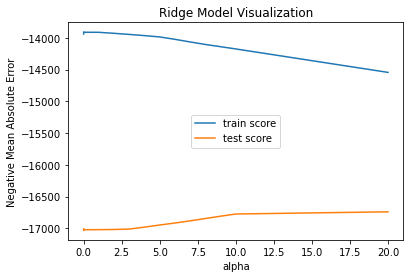

In [44]:
# plotting mean test and train scoes with alpha 
cv_results['param_alpha'] = cv_results['param_alpha'].astype('int32')

# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')
plt.title("Ridge Model Visualization")
plt.legend(['train score', 'test score'], loc='center')
plt.show()

In [45]:
# get the best estimator for lambda
model_cv.best_estimator_

Ridge(alpha=20)

In [46]:
alpha = 20
ridge = Ridge(alpha=alpha)

ridge.fit(X_train_final, Y_train)
ridge.coef_

array([ 3004.66661477,  7539.03390464,  8284.1678731 ,  8699.19978226,
       -1145.3844499 , -2080.2147289 , -2307.34536283,    76.58878609,
        2259.49879517,  2865.93141194])

In [47]:
Y_train_ridge = Y_train.copy()

In [48]:
from sklearn.metrics import r2_score
model_ridge=ridge.fit(X_train_final, Y_train_ridge)
# predict
y_train_pred = ridge.predict(X_train_final)
print(model_ridge.score(X_train_final, Y_train_ridge))
print(r2_score(y_true=Y_train_ridge, y_pred=y_train_pred))

0.5287465910366019
0.5287465910366019


In [49]:
X_test_ridge = X_test[col10]
Y_test_ridge = Y_test.copy()

In [50]:
y_test_pred = ridge.predict(X_test_ridge)
print(model_ridge.score(X_test_ridge, Y_test_ridge))
print(r2_score(y_true=Y_test_ridge, y_pred=y_test_pred))

0.34990054241010493
0.34990054241010493


In [51]:
y_test_pred = ridge.predict(X_test_ridge)
print(model_ridge.score(X_test_ridge, Y_test_ridge))
print(r2_score(y_true=Y_test_ridge, y_pred=y_test_pred))

0.34990054241010493
0.34990054241010493


In [52]:
# Check the mean squared error

mean_squared_error(Y_test_ridge, ridge.predict(X_test_ridge))

417921641.12269557

Regularization -Reduces the variance without substantial increase in the bias. Normally we keep the same number of features, but reduce the magnitude of the coefficients.

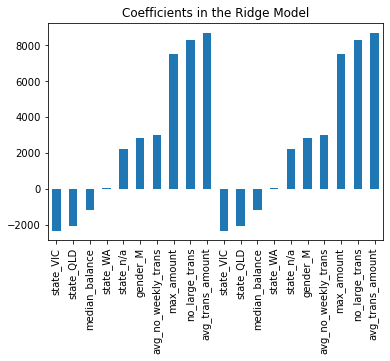

In [53]:
# Plot important coefficients - To check the magnitude of the co-efficients 

coefs = pd.Series(ridge.coef_, index = X_train_final.columns)

imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "bar")
plt.title("Coefficients in the Ridge Model")

plt.show()

In [54]:
ridge_df = pd.DataFrame() 
ridge_df['Coeff Values'] = pd.Series(ridge.coef_) 
ridge_df['Variables'] = X_train_final.columns

# Removing rows that have coeff = 0
ridge_df = ridge_df.loc[ridge_df['Coeff Values']!=0]

ridge_df['Absolute Coefficent'] =ridge_df['Coeff Values'].apply(lambda x:abs(x))
ridge_df.sort_values(by=['Absolute Coefficent'],inplace=True,ascending=False)

print(ridge_df.head(20))

   Coeff Values            Variables  Absolute Coefficent
3   8699.199782     avg_trans_amount          8699.199782
2   8284.167873       no_large_trans          8284.167873
1   7539.033905           max_amount          7539.033905
0   3004.666615  avg_no_weekly_trans          3004.666615
9   2865.931412             gender_M          2865.931412
6  -2307.345363            state_VIC          2307.345363
8   2259.498795            state_n/a          2259.498795
5  -2080.214729            state_QLD          2080.214729
4  -1145.384450       median_balance          1145.384450
7     76.588786             state_WA            76.588786


#### Lasso 

In [55]:
X_train_lasso = X_train[col10]

In [56]:
lasso = Lasso()
folds = 10

params = {'alpha': [0.0001, 0.001,0.002,0.003,0.005,0.008]}


# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train_lasso, Y_train) 

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    0.6s finished


GridSearchCV(cv=10, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.002, 0.003, 0.005, 0.008]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [57]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.004588,0.001252,0.003336,0.000835,0.0001,{'alpha': 0.0001},-21323.294366,-17237.766057,-13706.743498,-10155.667103,...,-14452.565376,-14894.622514,-13354.812218,-14271.825152,-14225.709573,-14289.105901,-14389.306943,-14413.084167,-14189.334030,409.333049
1,0.004303,0.001400,0.003012,0.000643,0.001,{'alpha': 0.001},-21323.296050,-17237.763556,-13706.743504,-10155.666176,...,-14452.565030,-14894.622244,-13354.812982,-14271.824599,-14225.709147,-14289.105652,-14389.306876,-14413.083421,-14189.333764,409.332835
2,0.005012,0.000822,0.003729,0.001557,0.002,{'alpha': 0.002},-21323.297923,-17237.760779,-13706.743493,-10155.665146,...,-14452.564647,-14894.621944,-13354.813831,-14271.823985,-14225.708675,-14289.105374,-14389.306805,-14413.082594,-14189.333470,409.332596
3,0.004371,0.001247,0.003030,0.000213,0.003,{'alpha': 0.003},-21323.299796,-17237.758000,-13706.743539,-10155.664115,...,-14452.564261,-14894.621646,-13354.814679,-14271.823370,-14225.708202,-14289.105097,-14389.306732,-14413.081765,-14189.333175,409.332358
4,0.004932,0.001726,0.003851,0.000896,0.005,{'alpha': 0.005},-21323.303540,-17237.752445,-13706.743491,-10155.662056,...,-14452.563495,-14894.621046,-13354.816373,-14271.822141,-14225.707258,-14289.104542,-14389.306587,-14413.080108,-14189.332585,409.331882


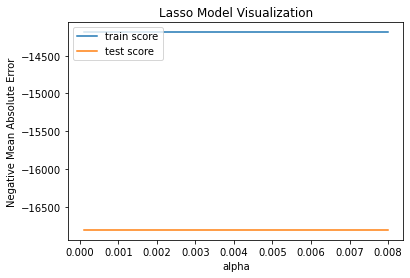

In [58]:
# plotting mean test and train scoes with alpha 
cv_results['param_alpha'] = cv_results['param_alpha'].astype('float32')

# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')

plt.title("Lasso Model Visualization")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

In [59]:
# get the best estimator for lambda
model_cv.best_estimator_

Lasso(alpha=0.008)

In [60]:
alpha =0.007

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train_lasso, Y_train) 

Lasso(alpha=0.007)

In [61]:
(lasso.coef_)

array([  6800.17822663,   9218.76473905,  10577.75721083,  14038.15496804,
       -15232.24653952,  -4921.91165465,  -2871.15322907,   1324.29045739,
         3556.50536995,   5215.18291602])

In [62]:
list(zip(X_train_lasso.columns,lasso.coef_))

[('avg_no_weekly_trans', 6800.178226626804),
 ('max_amount', 9218.764739051236),
 ('no_large_trans', 10577.75721082521),
 ('avg_trans_amount', 14038.154968035962),
 ('median_balance', -15232.246539520414),
 ('state_QLD', -4921.911654649526),
 ('state_VIC', -2871.153229074196),
 ('state_WA', 1324.2904573870014),
 ('state_n/a', 3556.505369950219),
 ('gender_M', 5215.182916016693)]

In [63]:
Y_train_lasso = Y_train.copy()

In [64]:
model_lasso=lasso.fit(X_train_lasso, Y_train_lasso)

# predict
y_train_pred = lasso.predict(X_train_lasso)
print(model_lasso.score(X_train_lasso, Y_train_lasso))
print(r2_score(y_true=Y_train_lasso, y_pred=y_train_pred))

0.5729247999490976
0.5729247999490976


In [65]:
X_test_lasso = X_test[col10]
Y_test_lasso = Y_test.copy()

In [66]:
y_test_pred = lasso.predict(X_test_lasso)
print(model_lasso.score(X_test_lasso, Y_test_lasso))
print(r2_score(y_true=Y_test_lasso, y_pred=y_test_pred))

-0.7134715839590939
-0.7134715839590939


In [67]:
# Check the mean squared error

mean_squared_error(Y_test_lasso, lasso.predict(X_test_lasso))

1101518926.1041152

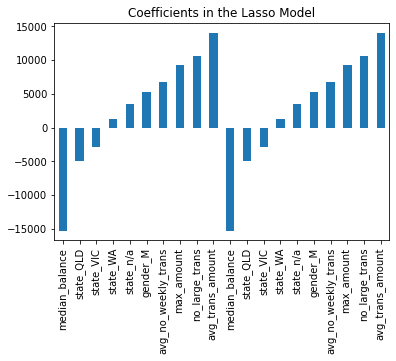

In [68]:
# Plot important coefficients

coefs = pd.Series(lasso.coef_, index = X_train_lasso.columns)

imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "bar")
plt.title("Coefficients in the Lasso Model")

plt.show()

In [69]:
lasso_df = pd.DataFrame() 
lasso_df['Coeff Values'] = pd.Series(lasso.coef_) 
lasso_df['Variables'] = X_train_lasso.columns

# Removing rows that have coeff = 0
lasso_df = lasso_df.loc[lasso_df['Coeff Values']!=0]

lasso_df['Absolute Coefficent'] =lasso_df['Coeff Values'].apply(lambda x:abs(x))
lasso_df.sort_values(by=['Absolute Coefficent'],inplace=True,ascending=False)

print(lasso_df.head(20))

   Coeff Values            Variables  Absolute Coefficent
4 -15232.246540       median_balance         15232.246540
3  14038.154968     avg_trans_amount         14038.154968
2  10577.757211       no_large_trans         10577.757211
1   9218.764739           max_amount          9218.764739
0   6800.178227  avg_no_weekly_trans          6800.178227
9   5215.182916             gender_M          5215.182916
5  -4921.911655            state_QLD          4921.911655
8   3556.505370            state_n/a          3556.505370
6  -2871.153229            state_VIC          2871.153229
7   1324.290457             state_WA          1324.290457


#### 4. Predict customers' annual salary
Now that our column transformer is ready, we can build a pipeline using the column transformer and a machine learning model to predict customers' annual salary.

Here, we will try two models:

- Linear regression
- Decision tree regressor

# 4.2 Decision tree 

In [72]:
# Instantiate model and pipeline 
tree = DecisionTreeRegressor()


In [74]:
# Fit pipeline and make predictions 
tree.fit(X_train, Y_train)
tree_pred = tree.predict(X_test)

In [75]:
# RMSE 
print("RMSE: ", round(np.sqrt(mean_squared_error(tree_pred, Y_test))))

RMSE:  34072


In [76]:
import statsmodels.api as sm

In [78]:
# Add a constant to get an intercept
X_train_sm = sm.add_constant(X_train)

# Fit the resgression line using 'OLS'
lr = sm.OLS(Y_train, X_train_sm).fit()

In [79]:
# Print the parameters, i.e. the intercept and the slope of the regression line fitted
lr.params

const                  61842.972608
avg_no_weekly_trans     6787.656068
max_amount              9268.139472
no_large_trans         10619.316873
avg_trans_amount       14000.688395
median_balance        -15210.844286
age                        0.056307
state_NT                -200.236673
state_QLD              -4970.198142
state_VIC              -2941.541644
state_WA                1277.210006
state_n/a               3472.992819
gender_M                5176.267895
dtype: float64

In [80]:
# Performing a summary operation lists out all the different parameters of the regression line fitted
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:          annual_salary   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     6.374
Date:                Thu, 12 Aug 2021   Prob (F-statistic):           5.31e-07
Time:                        13:49:18   Log-Likelihood:                -786.74
No. Observations:                  70   AIC:                             1599.
Df Residuals:                      57   BIC:                             1629.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                6.184e+04   3

In [81]:
import statsmodels.api  as sm
#Train the model 
X_train_sm=sm.add_constant(X_train)
X_train_sm.head()
#Fitting the model 
lr=sm.OLS(Y_train,X_train_sm)
lr_model=lr.fit()
#TO get the constant value for the predictor var TV 
lr_model.params
lr_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          annual_salary   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     6.374
Date:                Thu, 12 Aug 2021   Prob (F-statistic):           5.31e-07
Time:                        13:49:56   Log-Likelihood:                -786.74
No. Observations:                  70   AIC:                             1599.
Df Residuals:                      57   BIC:                             1629.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                6.184e+04   3058.961     20.217      0.000    5.57e+04     6.8e+04
avg_no_weekly_trans  6787.6561   3651.583      1.859      0.068    -524.513    1.41e+04
max_amount           9268.1395   2694.133      3.440      0.001    3873.230    1.47e+04
no_large_trans       1.062e+04   2887.988      3.677      0.001    4836.221    1.64e+04
avg_trans_amount       1.4e+04   3595.064      3.894      0.000    6801.696    2.12e+04
median_balance      -1.521e+04   9238.362     -1.646      0.105   -3.37e+04    3288.657
age                     0.0563   2967.294    1.9e-05      1.000   -5941.847    5941.960
state_NT             -200.2367   2289.173     -0.087      0.931   -4784.227    4383.754
state_QLD           -4970.1981   3610.312     -1.377      0.174   -1.22e+04    2259.328
state_VIC           -2941.5416   3353.138     -0.877      0.384   -9656.084    3773.001
state_WA             1277.2100   2785.615      0.459      0.648   -4300.888    6855.308
state_n/a            3472.9928   3656.003      0.950      0.346   -3848.026    1.08e+04
gender_M             5176.2679   2680.185      1.931      0.058    -190.710    1.05e+04
==============================================================================
Omnibus:                        0.255   Durbin-Watson:                   2.211
Prob(Omnibus):                  0.880   Jarque-Bera (JB):                0.060
Skew:                          -0.070   Prob(JB):                        0.970
Kurtosis:                       3.034   Cond. No.                         6.46
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [87]:
y_train_pred = lr_model.predict(X_train_sm)
y_train_pred

32     58849.810703
6      94147.904779
3      70525.932344
12     47004.838764
51     66218.016532
          ...      
79     49738.812317
87     37104.909745
67     47004.524602
24     57278.674967
8     100291.799134
Length: 70, dtype: float64

5. Conclusion

The RMSE for both models are over $20,000 and although decision tree performed better than linear regression by having a smaller RMSE, both models still appear to be highly inaccurate. Therefore, it is risky to use them to predict customers' income bracket. More data is required to develop a more reliable model.

 I doubt the result will be materially different as we only have a very limited amount of data (100 salaries) available.